# Law, Bias, and Algorithms
## Tests for discrimination

In [4]:
# Some initial setup
options(digits = 3)

library(tidyverse)

# Read the data
stop_df <- read_rds("../data/sqf_sample.rds")

theme_set(theme_bw())

### The data

The loaded data frame, `stop_df`, is a sample of stops in NYC, recorded on a 
[UF-250 form][uf250_link]

Below is a list of columns in the data, roughly corresponding to the [UF-250 form][uf250_link]:

* Base information regarding stop:
    * `id`, `year`, `date`, `time`, `precinct`, `location_housing`, 
      `suspected_crime`

* Circumstances which led to stop:
    * `stop_reason_object`, `stop_reason_desc`, `stop_reason_casing`,
      `stop_reason_lookout`, `stop_reason_clothing`, `stop_reason_drugs`,
      `stop_reason_furtive`, `stop_reason_violent`, `stop_reason_bulge`,
      `stop_reason_other` 
    
* Suspect demographics:
    * `suspect_dob`, `suspect_id_type`, `suspect_sex`, `suspect_race`,
      `suspect_hispanic`, `suspect_age`, `suspect_height`, `suspect_weight`,
      `suspect_hair`, `suspect_eye`, `suspect_build`, `reason_explained`,
      `others_stopped`

* Whether physical force was used:
    * `force_hands`, `force_wall`, `force_ground`, `force_drawn`,
      `force_pointed`, `force_baton`, `force_handcuffs`,
      `force_pepper`, `force_other`

* Was suspect arrested?: `arrested`

* Was summons issued?: `summons_issued`

* Officer in uniform?: `officer_uniform`, `officer_verbal`, `officer_shield`

* Was person frisked?: `frisked`
    * if yes: `frisk_reason_suspected_crime`, `frisk_reason_weapons`, 
      `frisk_reason_attire`, `frisk_reason_actual_crime`, 
      `frisk_reason_noncompliance`, `frisk_reason_threats`,
      `frisk_reason_prior`, `frisk_reason_furtive`, `frisk_reason_bulge`

* Was person searched?: `searched`,
    * if yes: `searched_hardobject`, `searched_outline`,
      `searched_admission`, `searched_other`

* Was weapon found?: `found_weapon`
    * if yes: `found_gun`, `found_pistol`, `found_rifle`, `found_assault`,
      `found_knife`, `found_machinegun`, `found_other`
      
* Was other contraband found?: `found_contraband`

* Additional circumstances/factors
    * `additional_report`, `additional_investigation`, `additional_proximity`, 
      `additional_evasive`, `additional_associating`, `additional_direction`, 
      `additional_highcrime`, `additional_time`, `additional_sights`, 
      `additional_other`

* Additional reports prepared: `extra_reports`

[uf250_link]: https://www.prisonlegalnews.org/media/publications/Blank%20UF-250%20Form%20-%20Stop%2C%20Question%20and%20Frisk%20Report%20Worksheet%2C%20NYPD%2C%202016.pdf
      

### Exercise 1: Initial exploration

* Compare columns of `stop_df` with the fields in the [UF-250 form][uf250_link].
* Explore basic statistics, e.g.,
    * What date range does our data cover?
    * What is the proportion of stops by `suspect_race`?
    * What are the five most common suspected crimes for a stop?
    * What proportion of stops result in retrieval of weapon or contraband?
* If you were to predict whether an officer would frisk a stopped individual, which columns/fields could you use? (i.e., which of the columns are pre/post frisk?)

[uf250_link]: https://www.prisonlegalnews.org/media/publications/Blank%20UF-250%20Form%20-%20Stop%2C%20Question%20and%20Frisk%20Report%20Worksheet%2C%20NYPD%2C%202016.pdf


In [2]:
# WRITE CODE HERE
# START solution
# Date range
stop_df %>%
    summarize(
        start = min(date),
        end = max(date)
    ) 

# Proportion of stops suspect race
stop_df %>%
    group_by(suspect_race) %>%
    summarize(stop_prop = n()/nrow(.))

# Top five suspected crimes
stop_df %>%
    group_by(suspected_crime) %>%
    summarize(count = n()) %>%
    arrange(desc(count)) %>%
    top_n(5, count)

# Proportion of "successful" stop (weapon or contraband found)
stop_df %>% 
    mutate(success = found_weapon | found_contraband) %>%
    summarize(p_success = mean(success))
# END solution

start,end
2008-01-01,2011-12-31


suspect_race,stop_prop
white,0.127
black,0.548
hispanic,0.325


suspected_crime,count
cpw,29087
robbery,21230
burglary,10424
grand larceny auto,10005
other,8192


p_success
0.0511


For the rest of the class, we'll be focusing on frisk data.

### Exercise 2: Frisk rates 

In considering whether there are racial disparities at the decision to frisk, we can compare frisk rates of minorities to frisk rates of white individuals. In other words, are whites who are stopped frisked more or less often than minorities who are stopped? Recall that the legal justification for a frisk is reasonable articulable suspicion (RAS) that the suspect posesses a weapon. Comparing frisk rates thus relies on the assumption that RAS is equally distributed among the stopped population. In this context, the stopped population is often called the *benchmark*.)

* What is the proportion of frisks by `suspect_race`? 
* What are the frisk rates (i.e., frisks benchmarked to the stopped population) by `suspect_race`? 
* What information can you draw from these two tables?

In [94]:
# WRITE CODE HERE
# START solution
# Proportion of frisks suspect race
stop_df %>%
    filter(frisked) %>%
    group_by(suspect_race) %>%
    summarize(prop = n()/nrow(.))

# Frisk rate for stopped suspects by suspect race
stop_df %>%
    group_by(suspect_race) %>%
    summarize(p_frisked = mean(frisked))
# END solution

suspect_race,prop
white,0.103
black,0.569
hispanic,0.328


suspect_race,p_frisked
white,0.576
black,0.740
hispanic,0.719


### Exercise 3: Dealing with confounders

Even if one race group has higher frisk rates than another, one could make the argument that officers might have a legitimate reason to frisk certain individuals more often; it just so happens that the reason is also highly correlated with race. Such a reason is often called a *confounding variable*. We'll discuss an example of this from our data in a moment.

Presence of a confounding variable would imply that our assumption in Exercise 2 (that among stopped individuals, all race groups exhibit RAS at equal rates) is missing the mark. If this confounding variable is strongly correlated with RAS and is also unevenly distributed across race groups, then our benchmark (i.e., comparing frisk rates) would be misrepresenting disparities.

Note from Exercise 1 that the most commonly suspected crime is *cpw*, criminal possession of a weapon. Given that the primary justification of a frisk is concern for officer safety, one could argue that it is reasonable for an officer to 
frisk individuals whom they have stopped under suspicion of criminal posession of weapons. It would thus make sense for cpw stops to have higher frisk rates. And if a larger proportion of minority stops were cpw stops, then we might correspondingly expect frisk rates to be higher among minority groups, due to this confounder.

To test this theory, first create a new binary column in `stop_df` named `is_cpw` that is `TRUE` if `suspected_crime` is `cpw`. 

In [3]:
# WRITE CODE TO ADD is_cpw column HERE
# START solution
stop_df <- stop_df %>%
    mutate(is_cpw = suspected_crime == "cpw")
# END solution

Now answer the following:
* What proportion of stops were cpw stops, by `suspect_race`?
* Among cpw stops, what are the frisk rates by `suspect_race`? Among non-cpw stops, what are the frisk rates by `suspect_race`?
* *Hint:* For the two tasks above, your new `is_cpw` column might come in handy!
* Summarize your findings. Does `is_cpw` seem like a confounding variable? Does there still appear to be racial disparities in frisk rates even after accounting for whether a stop was cpw or not?

In [110]:
# WRITE CODE HERE
# START solution
# Proportion of stops that were cpw, by suspect race
stop_df %>%
    group_by(suspect_race) %>%
    summarize(p_cpw = mean(is_cpw))

# Frisk rate for stopped suspects by suspect race and cpw
stop_df %>%
    group_by(is_cpw, suspect_race) %>%
    summarize(p_frisked = mean(frisked))
# END solution

suspect_race,p_cpw
white,0.117
black,0.354
hispanic,0.252


is_cpw,suspect_race,p_frisked
FALSE,white,0.531
FALSE,black,0.627
FALSE,hispanic,0.644
TRUE,white,0.910
TRUE,black,0.946
TRUE,hispanic,0.941


### Omitted variable bias

Following the above logic, there could be multiple legitimate factors that account for the observed discrepency of being frisked between different race groups. (We'll do this with a more formal statistical model next week.)

* Explore `stop_df`, and discuss what variables (columns) should be accounted for when measuring disparate impact of frisk on race.
* What variables definitely should (or should *not*) be included?
* What variables would you want to account for that we don't have access to?

The notion that there's some additional factor that we're not accounting for that would "explain away" the disparities is called *omitted variable bias*. The argument is often made that the omitted variable is something that's not even recorded in the data.


### The outcome test

The outcome test, first proposed by Gary Becker in 1957, attempts to get around *omitted variable bias* by focusing on differences in outcomes of post-stop actions (for example, recovery of weapons from frisks), and checking if outcomes differ systematically between whites and minorities. If frisked minorities are less likely than whites to have weapons, it suggests that the bar for frisking minorities is lower than the bar for frisking whites. That lower bar is de facto descrimination.

**Discuss with a partner:** 
* How does the outcome test circumvent omitted variable bias? 
* What is implied by accounting for confounders in the outcome test versus the original benchmarking context?

**Discuss with a partner:** How could the outcome test be applied to test discrimination/bias in the case of lending decisions? Bail bond-setting decisions? Editorial acceptance decisions? What would evidence of bias against minorities look like in each of these three decision-making arenas?

### Exercise 4: Computing hit rates

Jumping back to our NYC data, to apply the outcome test, we want to compute weapon recovery rates (or "hit rates") by race. 

* **Step 1:** Compute hit rates by race: weapons found divided by frisks conducted.

In [120]:
# Compute hit rates by race
# WRITE CODE HERE
# START solution
stop_df %>% 
  filter(frisked) %>%
  group_by(suspect_race) %>%
  summarize(hit_rate = mean(found_weapon))
# END solution

suspect_race,hit_rate
white,0.0422
black,0.0270
hispanic,0.0339


* **Discuss with a partner:** What do you find? How can that be interpreted?

An important thing to note is that all the work we've done so far has been citywide.

* **Step 2**: Compute hit rates by race and precinct.

In [151]:
# Compute hit rates by race and department
# Save your result to `precinct_hit_rates_by_race`
# WRITE CODE HERE
# START solution
precinct_hit_rates_by_race <-
  stop_df %>%
  filter(frisked) %>%
  group_by(suspect_race, precinct) %>%
  summarize(hit_rate = mean(found_weapon))
# END solution

Next we want to explore these hit rates by police precinct, comparing white versus minority hit rates. Reshaping the data might be helpful in doing this: **TODO: do this for them**

In [152]:
# Reshape data to have a white_rate, minority_rate, and minority_race column
# Save your result to `white_vs_minority_rates`
# Hint: the `spread()` and `gather()` functions might be helpful.
# WRITE CODE HERE
# START solution
white_vs_minority_rates <-
  precinct_hit_rates_by_race %>%
  spread(suspect_race, hit_rate) %>%
  rename(white_rate = white) %>%
  gather(minority_race, minority_rate, c(black, hispanic)) %>%
  filter(!is.na(minority_rate), !is.na(white_rate)) 
# END solution

If you have time, explore `precinct_hit_rates_by_race` and `white_vs_minority_rates`. Here are some questions to get you started, but you're encouraged to explore your own questions!
*  Do precincts have similar hit rates, or is there a wide spread?
*  What's the precinct with the highest hit rates? The lowest hit rates?
*  What's the precinct with the largest disparity between black and white hit rates?
*  Do any precincts have have higher hit rates for black drivers than for white drivers?

**Discuss with a partner:** Talk about your findings above. Do differences in hit rates imply officers of certain precincts are more discriminatory than others? What if frisk policies vary by location? What would it mean for different precincts in the city to encourage more or less stringent standards of suspicion prior to conducting frisks?

At this point, with over 200 hit rates to compare (1 for each race and precinct), in order to really understand citywide trends, we need some way to visualize our findings. Run the code below to generate a plot for hit rates by race and precinct.

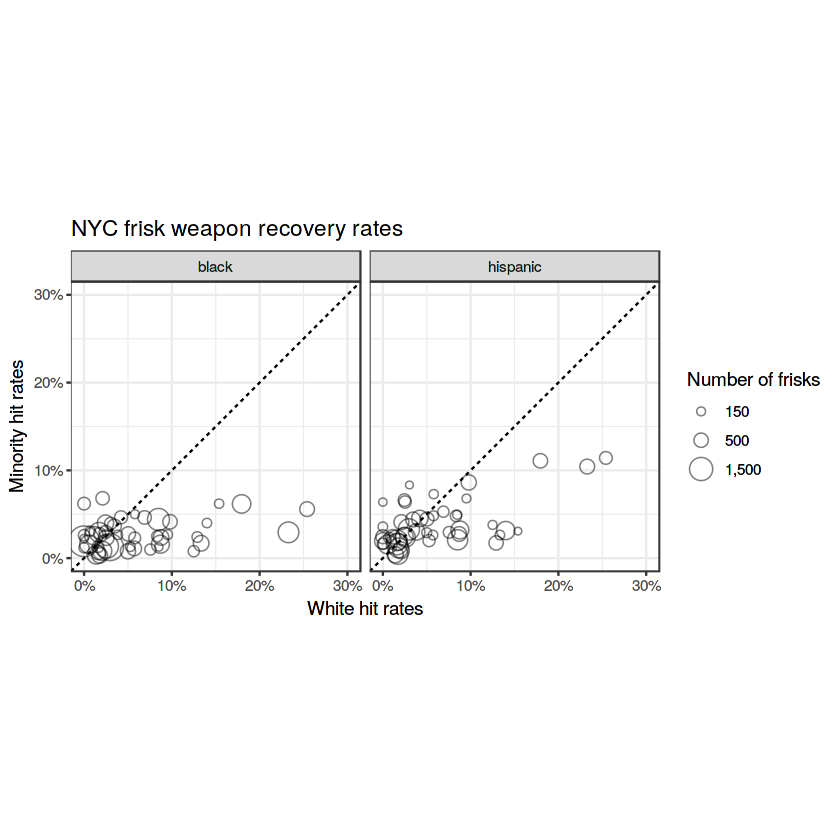

In [171]:
# to ensure our visualization isn't biased by precincts with little data,
# we filter to the precincts that have some minimum number of frisks, MIN_FRISKS,
# for each race
MIN_FRISKS <- 20

n_frisks <-
    stop_df %>%
    filter(frisked) %>%
    count(precinct, suspect_race) %>%
    spread(suspect_race, n) %>%
    filter(black > MIN_FRISKS, white > MIN_FRISKS, hispanic > MIN_FRISKS) %>%
    gather(minority_race, n, black, hispanic) %>%
    mutate(n_frisks = white + n) %>%
    select(precinct, minority_race, n_frisks)

hit_rates <- inner_join(
    white_vs_minority_rates,
    n_frisks,
    by = c("precinct", "minority_race")
  )

hit_rates %>%
  ggplot(aes(x = white_rate, y = minority_rate)) +
  geom_point(aes(size = n_frisks), shape = 1, alpha = 0.5) +
  geom_abline(linetype = "dashed") +
  facet_grid(cols = vars(minority_race)) +
  coord_fixed() +
  scale_x_continuous(limits = c(0, 0.3), labels = scales::percent) +
  scale_y_continuous(limits = c(0, 0.3), labels = scales::percent) +
  scale_size_area(max_size = 8, labels = scales::comma, breaks = c(150, 500, 1500)) +
  labs(
    x = "White hit rates",
    y = "Minority hit rates",
    size = "Number of frisks",
    title = "NYC frisk weapon recovery rates"
  )

**Discuss with a partner:** 
* What do you see in the plot? How would you interpret this? 
* What do you think might change if we considered `is_cpw`? Is it valid to consider `is_cpw` in this context?